# Spectroscopy with XGA

This tutorial will show you how to perform basic photometric analyses on XGA sources, starting with how to generate spectra for a source using the SAS interface. Once I have demonstrated how to generate the spectra for a source, I will show how we can use the XSPEC interface to fit a model to the data, and then how we can retrieve the fit results.

I will also demonstrate the use of the spectrum product view method, to produce visualisations of spectra roughly equivalent to those that XSPEC produces. 

In [1]:
from astropy.units import Quantity
import numpy as np
import pandas as pd

from xga.samples import ClusterSample
from xga.sources import PointSource
from xga.sas import evselect_spectrum
from xga.xspec import single_temp_apec, power_law

I need to define some sources to help demonstrate, and I've chosen to define both a sample of galaxy clusters (to demonstrate fitting a standard absorbed plasma emission model), and a **point source don't know which type yet** to demonstrate the fitting of a redshift dependant absorbed power law). These are currently the only two models implemented in XGA.

Again I've chosen four clusters from the XCS-SDSS sample:

In [2]:
# Setting up the column names and numpy array that go into the Pandas dataframe
column_names = ['name', 'ra', 'dec', 'z', 'r500', 'r200', 'richness', 'richness_err']
cluster_data = np.array([['XCSSDSS-124', 0.80057775, -6.0918182, 0.251, 1220.11, 1777.06, 109.55, 4.49],
                         ['XCSSDSS-2789', 0.95553986, 2.068019, 0.11, 1039.14, 1519.79, 38.90, 2.83],
                         ['XCSSDSS-290', 2.7226392, 29.161021, 0.338, 935.58, 1359.37, 105.10, 5.99],
                         ['XCSSDSS-134', 4.9083898, 3.6098177, 0.273, 1157.04, 1684.15, 108.60, 4.79]])

# Possibly I'm overcomplicating this by making it into a dataframe, but it is an excellent data structure,
#  and one that is very commonly used in my own analyses.
sample_df = pd.DataFrame(data=cluster_data, columns=column_names)
sample_df[['ra', 'dec', 'z', 'r500', 'r200', 'richness', 'richness_err']] = \
    sample_df[['ra', 'dec', 'z', 'r500', 'r200', 'richness', 'richness_err']].astype(float)

# Defining the sample of four XCS-SDSS galaxy clusters
demo_smp = ClusterSample(sample_df["ra"].values, sample_df["dec"].values, sample_df["z"].values, 
                         sample_df["name"].values, r200=Quantity(sample_df["r200"].values, "kpc"),
                         r500=Quantity(sample_df["r500"].values, 'kpc'), richness=sample_df['richness'].values, 
                         richness_err=sample_df['richness_err'].values)

Generating products of type(s) ccf:   0%|          | 0/4 [00:00<?, ?it/s]

Pre-generating necessary products


Setting up Galaxy Clusters:  25%|██▌       | 1/4 [00:01<00:03,  1.22s/it]/home/dt237/software/anaconda3/envs/XGA/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/dt237/software/anaconda3/envs/XGA/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
Setting up Galaxy Clusters: 100%|██████████| 4/4 [00:04<00:00,  1.12s/it]


Here I'm defining a point source object for a Quasar at z~0.9, this object has no particular interest or significance (at least not to me), but it will be used to demonstrate the fitting of a powerlaw by XSPEC:

In [3]:
demo_src = PointSource(182.2416, 45.67667, 0.9254, name='PG1206+459')

Generating products of type(s) ccf: 100%|██████████| 1/1 [00:10<00:00, 10.53s/it]


## Generating Spectra for our sources

It is just as simple to generate spectra (both for sample objects and source objects) as it is to generate the photometric products that we used in the last tutorial. The primary extra information required by evselect_spectrum is a region in which to generate the spectra, for a galaxy cluster it might be an overdensity radius (like R$_{200}$ for instance), for a point source we would use the 'point' region, as defined on point source initilisation with the **point_radius** keyword argument.

You can also set the level of grouping that you want to be applied to the spectrum (by the XMM SAS routine specgroup), using the **min_counts**, **min_sn**, and **over_sample** keyword arguments.

If the **one_rmf** keyword argument is set to True (as is the default) then only one RMF per ObsID-instrument combo will be generated, and will be used by any future spectrum generation for the ObsID-instrument combo. RMFs do change slightly with position on detector, but are also very computationally expensive to produce (relative to the other spectrum generation tasks), as such this is an acceptable compromise.

In [4]:
# For the Quasar, we want to use the point region type
demo_src = evselect_spectrum(demo_src, 'point')

# Whereas for my sample of clusters I've decided I want to use the R500 regions
demo_smp = evselect_spectrum(demo_smp, 'r500')

Preparing evselect spectrum commands:  25%|██▌       | 1/4 [00:02<00:06,  2.07s/it]/home/dt237/software/anaconda3/envs/XGA/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/dt237/software/anaconda3/envs/XGA/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/dt237/software/anaconda3/envs/XGA/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/dt237/software/anaconda3/envs/XGA/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/

## How XGA's XSPEC fits work

As XGA finds all available data relevant to a given source, we make sure to fit every spectrum we can generate, so as to get the best results. We do this by simultaneously fitting all of the spectra with the same model, making sure to link the key parameters so that the values are the result of minimising the difference of a single model to all the data.

The only parameter that is not linked by default is the model normalisation, which is allowed to vary on a spectrum by spectrum basis. 

I have written a general XSPEC fitting script, that in theory can deal with any model setup, and which is populated by XGA before being run for a specific source. Then the fit, luminosity, and plotting values are extracted and read into XGA. 

Just as when we generate SAS products, this process runs in parallel, with four different source fits all being executed on different cores (for example), this is especially useful when analysing large samples of objects.

## Fitting models to our sources

For the Quasar I've chosen a powerlaw, rather than any more complex model; there are two types of power law available to fit in the XGA XSPEC interface, an absorbed redshift dependant powerlaw (tbabs\*zpowerlw), and an absorbed redshift independent powerlaw (tbabs\*powerlaw). You can choose which to fit using the **redshifted** keyword argument when power_law (imported from xga.xspec) is called.

For those sources which have redshift information, luminosity values will always be calculated after a fit is performed. A call to an XGA XSPEC function allows you to choose which energy band to calculate the luminosity in (the defaults are between 0.5-2.0keV and between 0.01-100keV).

The user may also choose a photon index to use as the start value for the XSPEC fit, using the **start_pho_index** parameter. The energy range of the data that is to be fit to can be selected with the **lo_en** and **hi_en** parameters, but passing Astropy quantities (the default range is 0.3-7.9keV). The hydrogen column value is taken from the source object and is (by default) frozen during the fit, this behaviour can be changed with the **freeze_nh** keyword argument. The last option I will mention here is one that allows the user to choose to link the normalisation parameters of all the individual spectra.

In [5]:
demo_src = power_law(demo_src, 'point', redshifted=True)

Running XSPEC Fits: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


The model I have chosen to fit my clusters with is an absorbed APEC plasma emission model (tbabs\*apec), and the options you can pass into the function call are very similar to those of power_law. Start values for the temperature and metallicity of the plasma may be passed, along with parameters which will cause the nH and metallicity values to be frozen or unfrozen during the fit process:

In [6]:
demo_smp = single_temp_apec(demo_smp, 'r500')

Running XSPEC Fits: 100%|██████████| 4/4 [00:07<00:00,  1.91s/it]


## Viewing fitted spectra

Its just as easy to visualise a spectrum as it is to visualise the photometric products we explored in the last tutorial. We simply use the view() method on a spectrum object and a data + model plot will be shown:

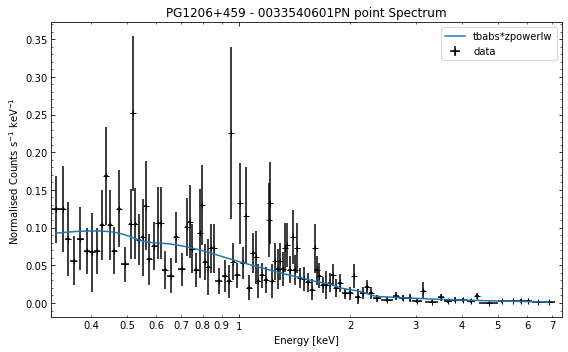

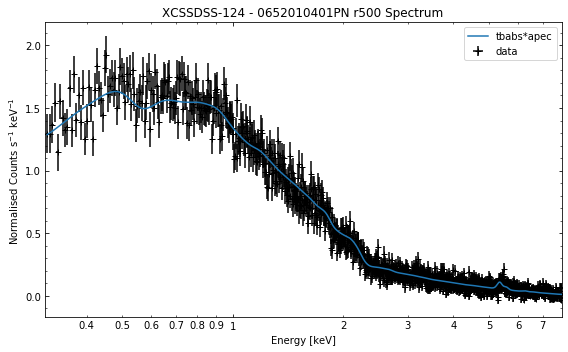

In [7]:
# We just grab a random spectrum from the Quasar source to demonstrate the view method
demo_src.get_products('spectrum')[0].view()

# We take a spectrum from the first cluster in our sample (XCSSDSS-124), and view that
demo_smp[0].get_products('spectrum')[0].view()

## General retrieval of fit parameters

Once we have performed a fit, we will almost certainly want to know what the values of the fit parameters (as well as the uncertainties on those parameters). It is a simple matter to retrieve these fit values, you only need to supply the name of the model and the region the fit was run on. 

This information is passed into the 'get_results' method of a source object, and a dictionary of parameter values + uncertainties will be returned. For the Quasar we have analysed as an example, the 'PhoIndex' entry is a numpy array with three values, the first column is the parameter value, the second column is the -error on the value, and the third column is the +error.

You will also notice below that the norm parameter entry is a three by three array. This is because this source has three spectra associated with it (0033540601PN, MOS1, and MOS2), and we didn't set **link_norm** equal to True when we ran the fit, as such three different values of normalisation are recorded.

In [8]:
demo_src.get_results('point', 'tbabs*zpowerlw')

{'PhoIndex': array([1.70316   , 0.06323976, 0.06449963]),
 'norm': array([[1.82057000e-04, 1.21461478e-05, 1.26249917e-05],
        [1.54701000e-04, 1.63470432e-05, 1.75980485e-05],
        [1.32958000e-04, 1.43496570e-05, 1.56008413e-05]])}

We can also use the exact same method on a GalaxyCluster source we get from our ClusterSample object. It is important to note that only parameters that are allowed to vary during the fit are saved in the fit paramater dictionaries. If, when we called 'single_temp_apec', we had allowed the nH and metalicity to vary, they would also have entries in the dictionary returned below:

In [9]:
demo_smp[0].get_results('r500', 'tbabs*apec')

{'kT': array([7.08241   , 0.13001988, 0.13005452]),
 'norm': array([[8.6856200e-03, 4.2672428e-05, 4.2798453e-05],
        [8.4306200e-03, 6.0591968e-05, 6.0800069e-05],
        [8.2131400e-03, 5.8739607e-05, 5.8965433e-05]])}

## Parameters from GalaxyCluster and ClusterSample objects

Galaxy Clusters are my particular area of study, and the source objects that I most commonly analyse with XGA. As such I have built in certain methods to make the retrieval of things like the intra-cluster medium temperature as simple as possible, both from sources directly and samples of clusters.

Again the only information we need to provide are the name of the model and the region that the fit was run on. The method to use is 'get_temperature', and the default model it tries to get values for is 'tbabs\*apec':

In [10]:
# We take an individual GalaxyCluster source and retrieve its temperature 
#  and -+ temperature errors
print(demo_smp[0].get_temperature('r500', 'tbabs*apec'))

[7.08241    0.13001988 0.13005452] keV


When dealing with a sample of Galaxy Clusters however, we often wish to know the properties of the entire population, in which case we can use the 'Tx' method of the ClusterSample. Again the model name and region must be known:

In [11]:
# This retrieves the T500 values (measured with tbabs*apec) for the whole sample
print(demo_smp.Tx('r500',  'tbabs*apec'))

[[7.08241    0.13001988 0.13005452]
 [4.71613    0.08232784 0.08245622]
 [5.36448    0.28213656 0.40367438]
 [6.71121    0.10219178 0.10230914]] keV


## Retrieving L$_\rm{x}$ values from sources and samples

As I mentioned earlier, if a source has a redshift associated with it then L$_\rm{X}$ values will automatically be measured as part of the fitting process. The use of X-ray luminosities in analysis is extremely common in X-ray astronomy, so I have introduced methods to retrieve luminosities from any source or sample object, in much the same way as we retrieve T$_{\rm{x}}$ values from GalaxyCluster and ClusterSample objects.



Seeing as L$_\rm{X}$s are measured within an energy band, I am defining the lower and upper limits of the measurement that I want to retrieve (as Astropy quantities), in this case the bolometric luminosity. If I didn't supply specific energy limits then the 'get_luminosities' method would supply all L$_\rm{X}$ measurements for the region-model combination in question.

Just as with the parameter dictionaries, the first column is the L$_\rm{X}$ value, the second is the -error, and the third is the +error:

In [12]:
lo_en = Quantity(0.01, 'keV')
hi_en = Quantity(100.0, 'keV')

In [13]:
# Grabbing the bolometric luminosity of the quasar we have investigated
print(demo_src.get_luminosities('point', 'tbabs*zpowerlw', lo_en=lo_en, hi_en=hi_en), '\n')

# And all the r500 luminosities of the first cluster in our sample
print(demo_smp[0].get_luminosities('r500', 'tbabs*apec'))

[2.73314742e+45 2.02796322e+44 2.01894887e+44] erg / s 

{'bound_0.5-2.0': <Quantity [6.34719765e+44, 2.56029780e+42, 2.75731230e+42] erg / s>, 'bound_0.01-100.0': <Quantity [2.4615566e+45, 2.5200763e+43, 1.7380108e+43] erg / s>}


In much the same way we can retrieve L$_\rm{X}$ values for an entire sample, and please note that this method can be used with any type of sample, not just ClusterSample objects:

In [14]:
# Bolometric luminosities for our sample of clusters
print(demo_smp.Lx('r500', 'tbabs*apec', lo_en=lo_en, hi_en=hi_en))

[[2.46155660e+45 2.52007630e+43 1.73801080e+43]
 [4.29973479e+44 4.93489920e+42 3.41495990e+42]
 [9.59239123e+44 3.80616320e+43 1.58674311e+43]
 [2.03981648e+45 1.06846200e+43 2.28873130e+43]] erg / s


A final note on XGA's L$_\rm{X}$ values. When XSPEC performs a simultaneous fit to multiple spectra, and then a luminosity is measured, it actually measures luminosities individually for all the spectra. As such, I had to make a decision about which L$_\rm{X}$ values I wanted XGA to report when requested from a source or sample object.

I chose to preferentially report a PN luminosity (because of the greater sensitivity compared to the MOS cameras). If a PN spectra was not available, then a MOS2 luminosity is taken instead, and if MOS2 wasn't available then a MOS1 luminosity will be used.